In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import sys
sys.path.append("../")

from machinelearning_fedbatch import main, plot_net_predictions
from src.utils import get_data_and_feed, plot_experiment, get_volume

FILENAME = "../data/data_processed.xlsx"
EXPERIMENT = "BR01"

Dataset shape: (11, 8)


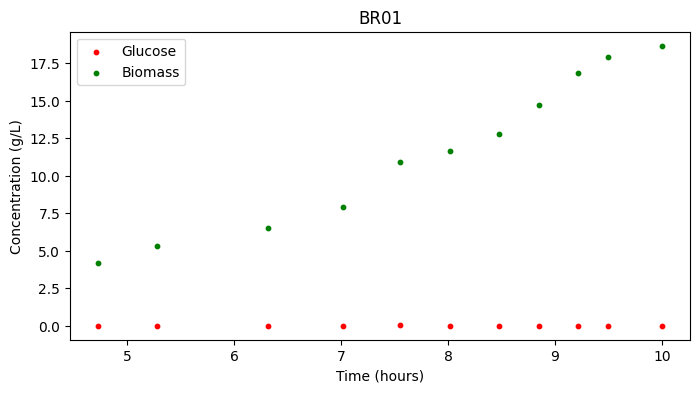

In [96]:
full_df, feeds = get_data_and_feed(file_name=FILENAME, experiment=EXPERIMENT, keep_only='FB')

print(f"Dataset shape: {full_df.shape}")

plot_experiment(full_df, title=EXPERIMENT)

In [97]:
train_df = full_df.iloc[:999]

net, u_pred, loss = main(train_df=train_df, full_df=full_df, feeds=feeds, Sin = 1.43 * 200, V0=1.55, num_epochs=10000)

Epoch 0, Loss 115.2298
mu_max: 0.6999, K_s: 0.1401, Y_xs: 0.5001
Epoch 100, Loss 15.8117
mu_max: 0.7026, K_s: 0.1378, Y_xs: 0.4939
Epoch 200, Loss 9.0504
mu_max: 0.7021, K_s: 0.1385, Y_xs: 0.4891
Epoch 300, Loss 8.6200
mu_max: 0.7020, K_s: 0.1387, Y_xs: 0.4835
Epoch 400, Loss 8.1494
mu_max: 0.7020, K_s: 0.1388, Y_xs: 0.4775
Epoch 500, Loss 7.4758
mu_max: 0.7021, K_s: 0.1387, Y_xs: 0.4715
Epoch 600, Loss 6.8494
mu_max: 0.7022, K_s: 0.1386, Y_xs: 0.4656
Epoch 700, Loss 6.0962
mu_max: 0.7021, K_s: 0.1387, Y_xs: 0.4604
Epoch 800, Loss 5.2956
mu_max: 0.7019, K_s: 0.1390, Y_xs: 0.4561
Epoch 900, Loss 4.4202
mu_max: 0.7013, K_s: 0.1396, Y_xs: 0.4532
Epoch 1000, Loss 3.7574
mu_max: 0.7008, K_s: 0.1402, Y_xs: 0.4518
Epoch 1100, Loss 3.2932
mu_max: 0.7005, K_s: 0.1404, Y_xs: 0.4518
Epoch 1200, Loss 3.1039
mu_max: 0.7004, K_s: 0.1406, Y_xs: 0.4535
Epoch 1300, Loss 3.0196
mu_max: 0.7011, K_s: 0.1399, Y_xs: 0.4553
Epoch 1400, Loss 2.9916
mu_max: 0.7016, K_s: 0.1394, Y_xs: 0.4579
Epoch 1500, Loss 3.

mu_max = 0.7514
Ks = 0.0966
Yxs = 0.5974


KeyError: 'Protein'

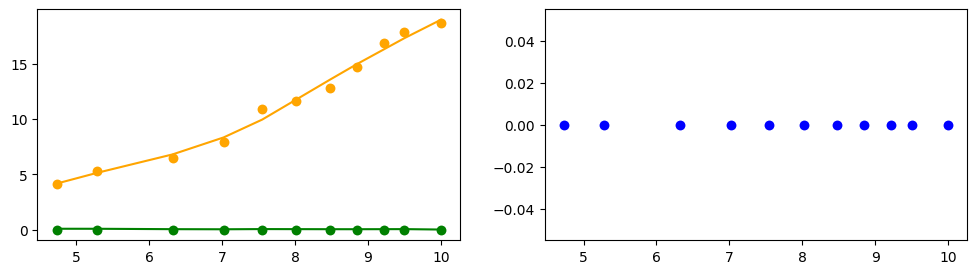

In [99]:
print(f'mu_max = {net.mu_max.item():.4f}')
print(f'Ks = {net.K_s.item():.4f}')
print(f'Yxs = {net.Y_xs.item():.4f}')    

title = f"mu_max = {net.mu_max.item():.4f}, Ks = {net.K_s.item():.4f}, Yxs = {net.Y_xs.item():.4f} | Loss = {loss:.4f}"
plot_net_predictions(full_df=full_df, train_df=train_df, u_pred=u_pred)